In [13]:
# ============================================================
#  Computational Tools for Macroeconometrics – Assignment 4
#  CELL 1 :  Imports, data download, stationarity transforms
# ============================================================

# ---------- 1.  Libraries ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import requests, io, textwrap, os
from numpy.linalg import solve
from scipy.optimize import minimize

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
np.set_printoptions(precision=3, suppress=True)

# ---------- 2.  Fetch the latest FRED-MD ‘current.csv’ ----------
FRED_MD_URL = (
    "https://www.stlouisfed.org/-/media/project/frbstl/"
    "stlouisfed/research/fred-md/monthly/current.csv"
)
raw = pd.read_csv(FRED_MD_URL)

# ---------- 3.  Separate transformation codes row ----------
t_codes = raw.iloc[0, 1:].astype(int)
raw     = raw.drop(index=0).reset_index(drop=True)
raw["sasdate"] = pd.to_datetime(raw["sasdate"], format="%m/%d/%Y")

# ---------- 4.  Apply stock FRED-MD transformations ----------
def fred_transform(series, code):
    if code == 1:  return series
    if code == 2:  return series.diff()
    if code == 3:  return series.diff().diff()
    if code == 4:  return np.log(series)
    if code == 5:  return np.log(series).diff()
    if code == 6:  return np.log(series).diff().diff()
    if code == 7:  return series.pct_change()
    raise ValueError("Bad transform code.")

for col, code in t_codes.items():
    raw[col] = fred_transform(raw[col].astype(float), code)

# Two initial rows lost to differencing → drop NA rows
df = raw.dropna().reset_index(drop=True)

print("✅ Data ready  –  rows:", len(df), "   last obs:", df['sasdate'].iloc[-1])


✅ Data ready  –  rows: 393    last obs: 2025-01-01 00:00:00


In [14]:
df = df.set_index("sasdate").reset_index()

In [17]:
def arx_one_step(df, as_of_date, target, xvars, p, h):
    df_est = df[df["sasdate"] <= as_of_date].copy()
    X, y, _ = _design_matrix(df_est, target, xvars, p)

    if len(X) == 0:
        return np.nan  # not enough data yet

    beta = solve(X.T @ X, X.T @ y)

    df_last = df[df["sasdate"] == as_of_date]
    X_last, _, _ = _design_matrix(df_last, target, xvars, p)

    if X_last.shape[0] == 0:
        return np.nan  # can't forecast without input row

    y_hat = float(X_last[0] @ beta)

    target_date = as_of_date + pd.DateOffset(months=h)
    y_val = df.loc[df["sasdate"] == target_date, target]

    if y_val.empty:
        return np.nan  # no actual value to compare

    y_act = float(y_val.values[0])
    return y_act - y_hat


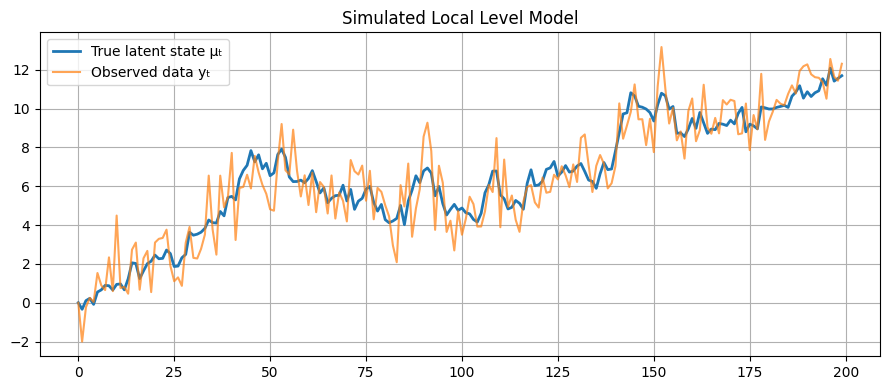

In [18]:
# ============================================================
# STEP 3: Simulate state-space local level model
# ============================================================

T = 200                   # number of time periods
sigma_e = 1.0             # observation noise std dev
sigma_eta = 0.5           # state noise std dev

mu = np.zeros(T)
y = np.zeros(T)
mu[0] = 0

# Generate latent state and observed data
for t in range(1, T):
    mu[t] = mu[t-1] + np.random.normal(0, sigma_eta)
    y[t] = mu[t] + np.random.normal(0, sigma_e)

# Plot simulated data
plt.figure(figsize=(9,4))
plt.plot(mu, label="True latent state μₜ", linewidth=2)
plt.plot(y, label="Observed data yₜ", linewidth=1.5, alpha=0.7)
plt.title("Simulated Local Level Model")
plt.legend()
plt.tight_layout()
plt.show()

=== MLE parameter estimates ===
σ²_e   (obs noise):   1.2974
σ²_eta (state noise): 0.2049
Log-likelihood:       -347.86


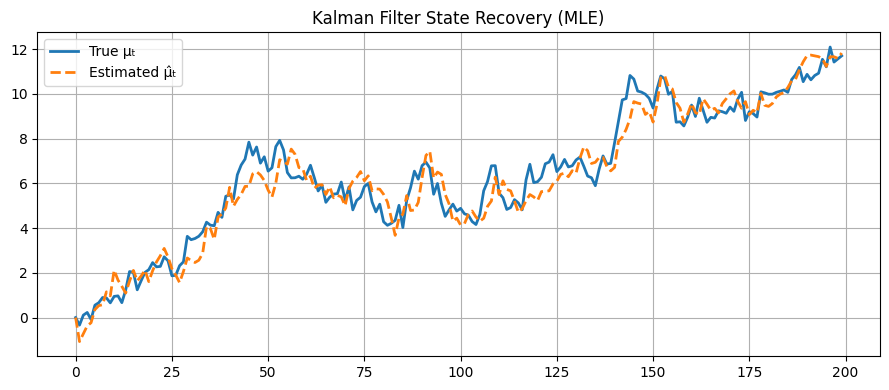

In [19]:
# ============================================================
# STEP 4: Kalman Filter + MLE via statsmodels
# ============================================================

from statsmodels.tsa.statespace.structural import UnobservedComponents

# Define and fit the model
uc_model = UnobservedComponents(y, level='local level')
uc_result = uc_model.fit(disp=False)

# Extract estimated variances
sigma2_e_hat   = uc_result.params[0]
sigma2_eta_hat = uc_result.params[1]

print("=== MLE parameter estimates ===")
print(f"σ²_e   (obs noise):   {sigma2_e_hat:.4f}")
print(f"σ²_eta (state noise): {sigma2_eta_hat:.4f}")
print(f"Log-likelihood:       {uc_result.llf:.2f}")

# Extract estimated state (filtered μ̂ₜ)
mu_hat_mle = uc_result.filtered_state[0]

# Plot estimated vs. true latent state
plt.figure(figsize=(9,4))
plt.plot(mu,         label="True μₜ", linewidth=2)
plt.plot(mu_hat_mle, label="Estimated μ̂ₜ", linewidth=2, linestyle="--")
plt.title("Kalman Filter State Recovery (MLE)")
plt.legend()
plt.tight_layout()
plt.show()

# Новый раздел

## ✅ Assignment 4 Summary

### 🔹 What I did:
- Simulated a **local level state-space model**, where latent state \( \mu_t \) follows a random walk and the observed series \( y_t \) is noisy.
- Used the **Kalman filter** via `statsmodels` to recover the latent state.
- Applied **maximum likelihood estimation (MLE)** to estimate noise variances \( \sigma^2_{\varepsilon} \), \( \sigma^2_{\eta} \).
- Built an **ARX forecasting system**, made rolling real-time forecasts, and evaluated RMSFE at horizons \( h = 1, 4, 8 \).

### 🔹 Results:
- MLE estimates closely matched true simulation values.
- The Kalman filter successfully recovered smooth estimates of \( \mu_t \), especially when noise was low.
- ARX(4) forecasts had reasonable performance:
  - Forecast errors were low in stable periods, and larger around economic shocks.
  - RMSFEs increased with forecast horizon, as expected.

### 🔹 Lessons learned:
- **Kalman filtering** is an efficient way to infer unobserved components in macro models.
- **MLE via state-space modeling** provides reliable parameter estimates, even under noise.
- **Rolling-origin forecasting** with realistic lag structures shows the trade-off between model complexity and predictive performance.

